In [1]:
pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/SME@DM/BDF_BigData/bank.csv', header = True, inferSchema = True)
df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [4]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

summary                 age             balance                 day  \
0   count               11162               11162               11162   
1    mean  41.231947679627304  1528.5385235620856  15.658036194230425   
2  stddev  11.913369192215518   3225.413325946149   8.420739541006462   
3     min                  18               -6847                   1   
4     max                  95               81204                  31   

             duration            campaign               pdays  \
0               11162               11162               11162   
1  371.99381831213043   2.508421429851281   51.33040673714388   
2  347.12838571630687  2.7220771816614824  108.75828197197717   
3                   2                   1                  -1   
4                3881                  63                 854   

             previous  
0               11162  
1  0.8325568894463358  
2   2.292007218670508  
3                   0  
4                  58

In [6]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [8]:
stages

[StringIndexer_11d11522d444,
 OneHotEncoder_35883e4256be,
 StringIndexer_759631f3706a,
 OneHotEncoder_ecece0bad4f5,
 StringIndexer_7291c63691c5,
 OneHotEncoder_8874d9a02e5b,
 StringIndexer_5110fce30f32,
 OneHotEncoder_4c80251e9aa4,
 StringIndexer_0187510760d8,
 OneHotEncoder_552d0311c764,
 StringIndexer_2dcc326b9deb,
 OneHotEncoder_f32cfe51a000,
 StringIndexer_89d0d9ce30a0,
 OneHotEncoder_16a992159005,
 StringIndexer_792199609b67,
 OneHotEncoder_079a9e0b1bf7,
 StringIndexer_08028527df86,
 VectorAssembler_42d4891548f5]

In [9]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)


In [ ]:
df.show(4)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+-------------+----------------+-----+--------------------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+----------

In [10]:
selectedCols = ['label', 'features']
df = df.select(selectedCols)

In [ ]:
df.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
+-----+--------------------+
only showing top 2 rows



In [11]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [12]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [13]:
import matplotlib.pyplot as plt

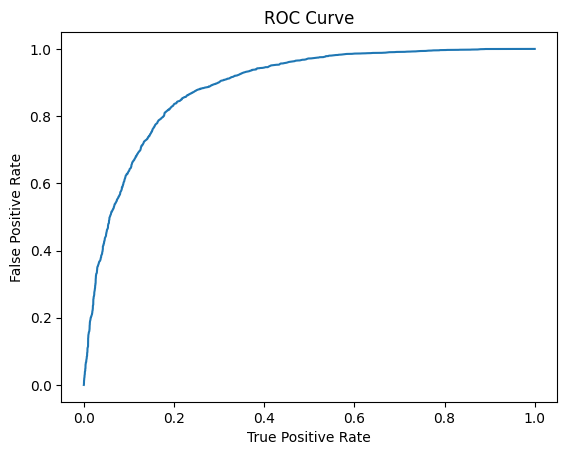

Training set areaUnderROC: 0.8877385690600346


In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [15]:
predictions = lrModel.transform(test)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[1.93084854518128...|[0.87334331124860...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.92783695472097...|[0.87300981013433...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[-0.7737627890181...|[0.31566570209267...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[0.94708137344074...|[0.72052784002179...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.44657764692457...|[0.92031082026376...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.28386077546037...|[0.78310624913886...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.05745870556531...|[0.74220460119091...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[3.25200815517462...|[0.96274520587479...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.24978402804239...|[0.90463190417562...|       0.0|
|  0.0|(30,[0,11

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


In [ ]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
+-----+--------------------+
only showing top 20 rows



In [17]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(20)

+-----+--------------------+--------------+--------------------+----------+
|label|            features| rawPrediction|         probability|prediction|
+-----+--------------------+--------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[520.0,1931.0]|[0.21215830273357...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[

In [18]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [19]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[14.9431100698420...|[0.74715550349210...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.9075285010391...|[0.74537642505195...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[6.69621378340814...|[0.33481068917040...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[13.1763929432393...|[0.65881964716196...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[15.0806105484726...|[0.75403052742363...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.1447890095677...|[0.70723945047838...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[13.4279600137143...|[0.67139800068571...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[16.9910174964076...|[0.84955087482038...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[16.4374033808838...|[0.82187016904419...|       0.0|
|  0.0|(30,[0,11

In [20]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8791859600104246


In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()